<a href="https://colab.research.google.com/github/mani2106/Competition-Notebooks/blob/master/Amazon_review_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Extract zip file

In [1]:
!unzip Dataset.zip

Archive:  Dataset.zip
   creating: Dataset/
  inflating: Dataset/Sample_Submission.csv  
  inflating: Dataset/test.csv        
  inflating: Dataset/train.csv       


### Import Required Libraries

In [0]:
from fastai.text import *

### Set constants

In [0]:
DATA_PATH = Path("./Dataset")

### View Data

In [3]:
train = pd.read_csv(DATA_PATH/'train.csv')
train.head()

,Review Text,Review Title,topic
0,"Did nothing for me, didn't help lost even with...",Useless,Shipment and delivery
1,"Did nothing for me, didn't help lost even with...",Useless,Not Effective
2,I have bought these bags and immediately open...,TRASH!!! Do not buy these bags it’s a waist of...,Customer Service
3,Gave me an allergic reaction on my face :(,Do not recommend,Allergic
4,These don't compare to the name brand wipes. F...,Can't tackle big messes,Texture


In [0]:
# def get_all_labels_for_observation(observation):
#     return train[train['Review Text'] == observation].topic.values

# def add_label_list_column(row):
#     row['topics'] = get_all_labels_for_observation(row['Review Text'])
#     return row

# labeled_df = train.apply(add_label_list_column, axis=1)

### Get DataBunch from csv

In [0]:
test = pd.read_csv(DATA_PATH/"test.csv")

In [0]:
data_lm = TextLMDataBunch.from_csv(DATA_PATH, 'train.csv',
                                   text_cols=[0,1], label_cols=[2],
                                   test='test.csv')

data_clas = TextClasDataBunch.from_csv(DATA_PATH, 'train.csv',
                                       text_cols = [0,1], label_cols=[2],
                                       vocab=data_lm.train_ds.vocab,
                                       bs=32, test='test.csv')

### Save embeddings

In [0]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [7]:
data_clas.show_batch()

text,target
"xxbos xxrep 6 ! xxunk mg of sodium per 1 scoop serving , with a recommended 1 - 2 xxunk possibly multiple times a day . "" xxmaj use between major meals and before and after exercise "" xxup xxunk . xxmaj do the xxunk ! xxmaj if you plan to use this to add some protein once a day and all else is pretty clean , then have at",Shipment and delivery
"xxbos i ’ve actually seen this at a drugstore , which is nice as i am not “ required ” to purchase online only , or have to drive out of my way to another store somewhere to get it . i have not seen other “ vision / lutein blue ” supplements out there , but then again , i have not been store - hopping with the intent",Quality/Contaminated
"xxbos i ’ve actually seen this at a drugstore , which is nice as i am not “ required ” to purchase online only , or have to drive out of my way to another store somewhere to get it . i have not seen other “ vision / lutein blue ” supplements out there , but then again , i have not been store - hopping with the intent",Not Effective
xxbos i 've been doing searching about sugar than fructose and solids and what i found out that i do n't know nutrition for the warning and other ingredients and all this stuff it came out to dextrose this girl 's is corn syrup same thing that messes with your pancreas to release more insulin in insulin production it goes everywhere and this stuff the optimal change the xxunk nutritious,Ingredients
"xxbos i 've been buying the 660 g container size of this product from my local organic foods store for approximately 3 months now . xxmaj at that store , the best price i 've been able to get is $ 25.99 per container , and that was on sale . xxmaj currently , it is selling at the store for $ 32.99 per container vs. a suggested retail price",Color and texture


### Create Language Model

In [0]:
from fastai.metrics import top_k_accuracy, accuracy_thresh

In [0]:
?accuracy_thresh

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, metrics=[top_k_accuracy])
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 3.63E-02


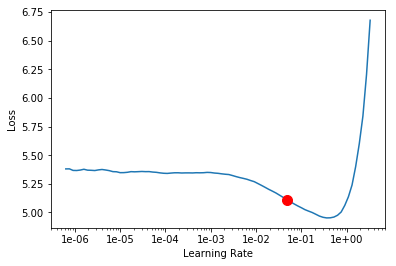

In [10]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr
# min_grad_lr

In [12]:
learn.fit_one_cycle(5, min_grad_lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,4.259892,3.721629,0.535134,00:14
1,3.801045,3.600229,0.554654,00:14
2,3.423052,3.414590,0.584063,00:14
3,3.063045,3.245727,0.609643,00:15
4,2.791260,3.208514,0.614866,00:15


In [0]:
learn.save('stage-2')
# learn.load('stage-1');

In [0]:
learn.freeze_to(-4)
# learn.unfr

In [15]:
learn.fit_one_cycle(5, slice(5e-3/3., 5e-3))

epoch,train_loss,valid_loss,top_k_accuracy,time
0,2.626318,3.065588,0.639275,00:19
1,2.443352,2.848713,0.672232,00:20
2,2.024430,2.653127,0.704409,00:20
3,1.619855,2.546727,0.722444,00:19
4,1.341837,2.541235,0.725815,00:19


In [0]:
learn.save_encoder('ft_enc')

### Build Classifier

In [0]:
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3, metrics=[top_k_accuracy])
classifier.load_encoder('ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-09
Min loss divided by 10: 7.59E-04


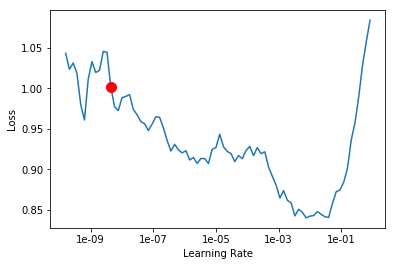

In [20]:
classifier.lr_find(start_lr=1e-11)
classifier.recorder.plot(suggestion=True)
min_grad_lr = classifier.recorder.min_grad_lr

In [21]:
classifier.fit_one_cycle(3, min_grad_lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,0.919725,0.730192,0.990772,00:09
1,0.884011,0.732649,0.993289,00:09
2,0.882442,0.725429,0.990772,00:12


In [0]:
classifier.save('top_n_99')
classifier.export('top_n_99.pkl')
# classifier.load('top_n_87');

In [0]:
# classifier.freeze_to()
# classifier.freeze()
# classifier.freeze_to(-3)

In [49]:
# classifier.fit_one_cycle(5, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,top_k_accuracy,time
0,1.514046,1.732296,0.881711,00:21
1,1.437093,1.451513,0.925336,00:18
2,1.083397,1.423325,0.937081,00:19
3,0.845939,1.416796,0.950503,00:17
4,0.645538,1.468561,0.951342,00:17


In [0]:
# classifier.save('top_n_95')
# classifier.export('top_n_95.pkl')

In [23]:
ss = pd.read_csv(DATA_PATH/'Sample_Submission.csv')
ss.head()

,Review Text,Review Title,topic
0,"Not terrible, but not good. Tastes burnt and a...",Not my cup o’ joe,Burnt/ Over -roast
1,"I am so disappointed, it has no flavor, doesn'...","I am so disappointed, it has no flavor",Bad Flavor/Taste
2,"I recently gave up my daily 6 cups of coffee, ...",Flavor was dissapointing,Bitter
3,Meh. I've adored Peruvian coffee for 20 years....,Smooth but majorly bland. Won't repurchase.,Bad Flavor/Taste
4,Meh. I've adored Peruvian coffee for 20 years....,Smooth but majorly bland. Won't repurchase.,Cheap


In [0]:
clas_preds = classifier.get_preds(data_clas.test_ds, with_loss=False)
# learn
# learn.predict?

In [0]:
y_pred = clas_preds[0].numpy() #.astype(int) 
y_true = clas_preds[1].numpy()

In [33]:
y_pred

array([[6.742468e-02, 1.658981e-02, 2.145550e-02, 2.087281e-04, ..., 4.169017e-02, 1.931577e-03, 1.889432e-02,
        1.412982e-03],
       [6.974443e-02, 5.485334e-03, 7.251654e-03, 1.637963e-04, ..., 3.834512e-02, 8.217791e-04, 7.387114e-02,
        1.417418e-03],
       [5.541558e-01, 2.277242e-02, 6.993747e-03, 1.727039e-04, ..., 2.019352e-02, 2.660832e-03, 1.960196e-02,
        1.365140e-03],
       [3.350814e-01, 1.089581e-02, 5.536528e-03, 7.881325e-05, ..., 6.724305e-02, 3.309262e-03, 2.003234e-02,
        6.154226e-04],
       ...,
       [1.488785e-02, 9.297016e-01, 2.836876e-03, 6.436646e-04, ..., 6.041799e-03, 1.435373e-03, 9.731487e-04,
        2.857491e-03],
       [4.429468e-06, 6.134563e-05, 2.047805e-06, 5.042589e-07, ..., 1.428038e-06, 6.231230e-08, 1.183284e-09,
        3.642903e-06],
       [4.429468e-06, 6.134563e-05, 2.047805e-06, 5.042589e-07, ..., 1.428038e-06, 6.231230e-08, 1.183284e-09,
        3.642903e-06],
       [3.023769e-05, 2.126300e-01, 2.638639e-04, 

In [34]:
y_true

array([10, 11,  0, 10, ...,  1, 14, 14, 14])

In [0]:
interp = TextClassificationInterpretation.from_learner(learn)

In [205]:
interp.show_intrinsic_attention('I used to be loyal customer to this brand. I have been using these gloves for 5 years. However, I just opened a new box today, and the smell is really really really bad (smell looks like you burn a plastic bag). Never paid attention before since the smell might not be so strong enough to notice. I am so disappointed and scared since I used it to cut fruits for my little one everyday. Now use it to wash dishes.')

In [206]:
interp.most_confused(min)

TypeError: ignored

In [183]:
test.iloc[5, 0]

'I used to be loyal customer to this brand. I have been using these gloves for 5 years. However, I just opened a new box today, and the smell is really really really bad (smell looks like you burn a plastic bag). Never paid attention before since the smell might not be so strong enough to notice. I am so disappointed and scared since I used it to cut fruits for my little one everyday. Now use it to wash dishes.'